## libraries for plots

In [2]:
#Loading libraries and the dataset suited for EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import calendar
import joypy
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df = pd.read_pickle('Hourly_Elec_Original_EDA.pkl')

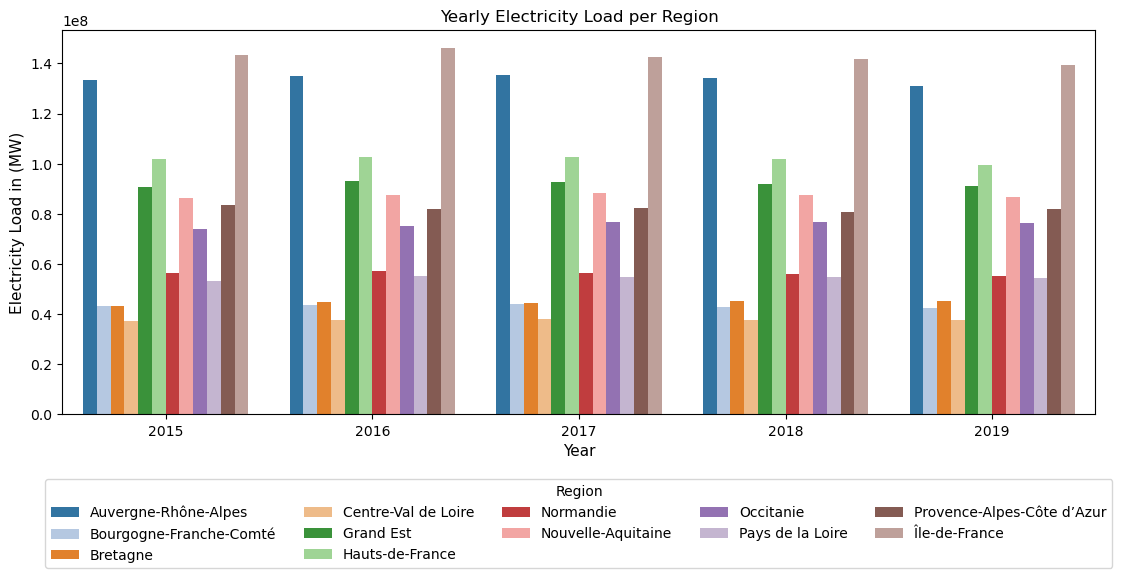

In [5]:
#Creating plot for yearly electriciy load per region per year

#Aggregrating the yearly load of demand per region
yearly_demand = (
    df.groupby(["year", "region_name"])["conso_elec_mw"]
    .sum()
    .reset_index()
)



#Creating the plot
plt.figure(figsize=(12,6))
sns.barplot(
    data=yearly_demand,
    x="year",
    y="conso_elec_mw",
    hue="region_name",
    palette="tab20"
)
plt.title("Yearly Electricity Load per Region", fontsize=12)
plt.xlabel("Year", fontsize = 11)
plt.ylabel("Electricity Load in (MW)", fontsize = 11)
plt.legend(title="Region", loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.tight_layout()
plt.savefig("Yearly_Load_Per_region_bar.pdf", format='pdf', bbox_inches='tight')
plt.show()


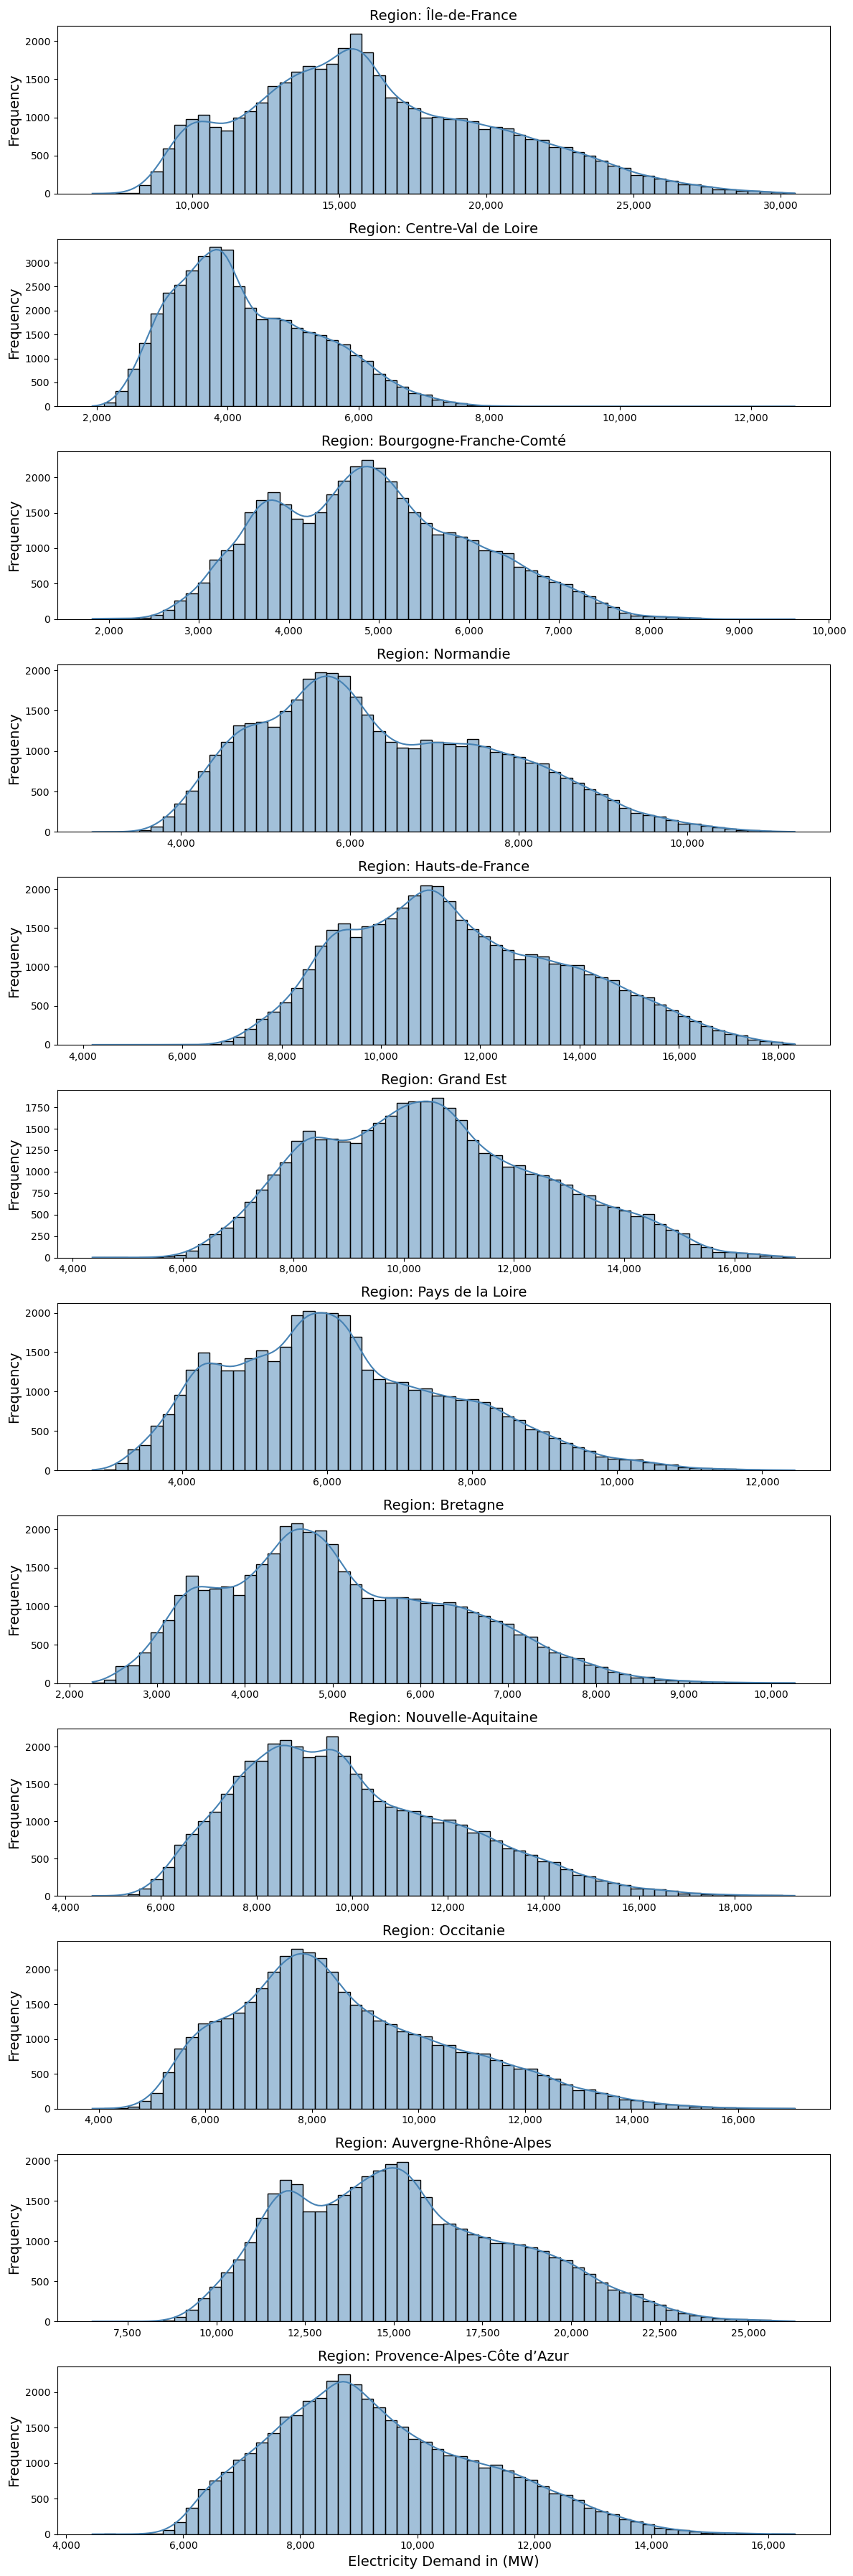

In [7]:
# Getting the unique region names 
regions = df["region_name"].unique()


#Creating the subplots for the regional electricity load distributions
fig, axes = plt.subplots(len(regions), 1, figsize=(12, 3 * len(regions)), sharex=False)

for i, region in enumerate(regions):
    sns.histplot(
        data=df[df["region_name"] == region],
        x="conso_elec_mw",
        bins=60,
        kde=True,   # True set to get a smooth curve
        ax=axes[i],
        color="steelblue"
    )
    axes[i].set_title(f"Region: {region}", fontsize=14)
    axes[i].set_ylabel("Frequency", fontsize = 14)
    axes[i].set_xlabel('')
    axes[i].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f'{int(x):,}'))

# Having one xlabel for all the plts
plt.xlabel("Electricity Demand in (MW)", fontsize = 14)
plt.tight_layout()
plt.savefig("Yearly_Load_Frequency_Per_region.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [17]:
#Create the dictionary for the ADF test
adf_results = {}

# making a for loop to go through all the regions
for region in df["region_name"].unique():
    region_data = df[df["region_name"] == region]["conso_elec_mw"]
    
    #Running the Augmented dickey fuller test
    result = adfuller(region_data, autolag="AIC")
    
    adf_results[region] = {
        "ADF Statistic": result[0],
        "p-value": result[1],
        "Critical Values": result[4]
    }

# showing the results 
for region, res in adf_results.items():
    print(f"Region: {region}")
    print(f"  ADF Statistic: {res['ADF Statistic']:.4f}")
    print(f"  p-value: {res['p-value']:.4f}")
    print(f"  Critical Values: {res['Critical Values']}")
    if res['p-value'] < 0.05:
        print("Result: Stationary (reject null hypothesis)")
    else:
        print("Result: Non-stationary (fail to reject null hypothesis)")

Region: Île-de-France
  ADF Statistic: -7.4170
  p-value: 0.0000
  Critical Values: {'1%': -3.4304993999387716, '5%': -2.861606031497663, '10%': -2.5668051464183854}
Result: Stationary (reject null hypothesis)
Region: Centre-Val de Loire
  ADF Statistic: -8.0149
  p-value: 0.0000
  Critical Values: {'1%': -3.4304993999387716, '5%': -2.861606031497663, '10%': -2.5668051464183854}
Result: Stationary (reject null hypothesis)
Region: Bourgogne-Franche-Comté
  ADF Statistic: -9.5541
  p-value: 0.0000
  Critical Values: {'1%': -3.4304993999387716, '5%': -2.861606031497663, '10%': -2.5668051464183854}
Result: Stationary (reject null hypothesis)
Region: Normandie
  ADF Statistic: -7.5255
  p-value: 0.0000
  Critical Values: {'1%': -3.4304993999387716, '5%': -2.861606031497663, '10%': -2.5668051464183854}
Result: Stationary (reject null hypothesis)
Region: Hauts-de-France
  ADF Statistic: -8.1852
  p-value: 0.0000
  Critical Values: {'1%': -3.4304993999387716, '5%': -2.861606031497663, '10%': -

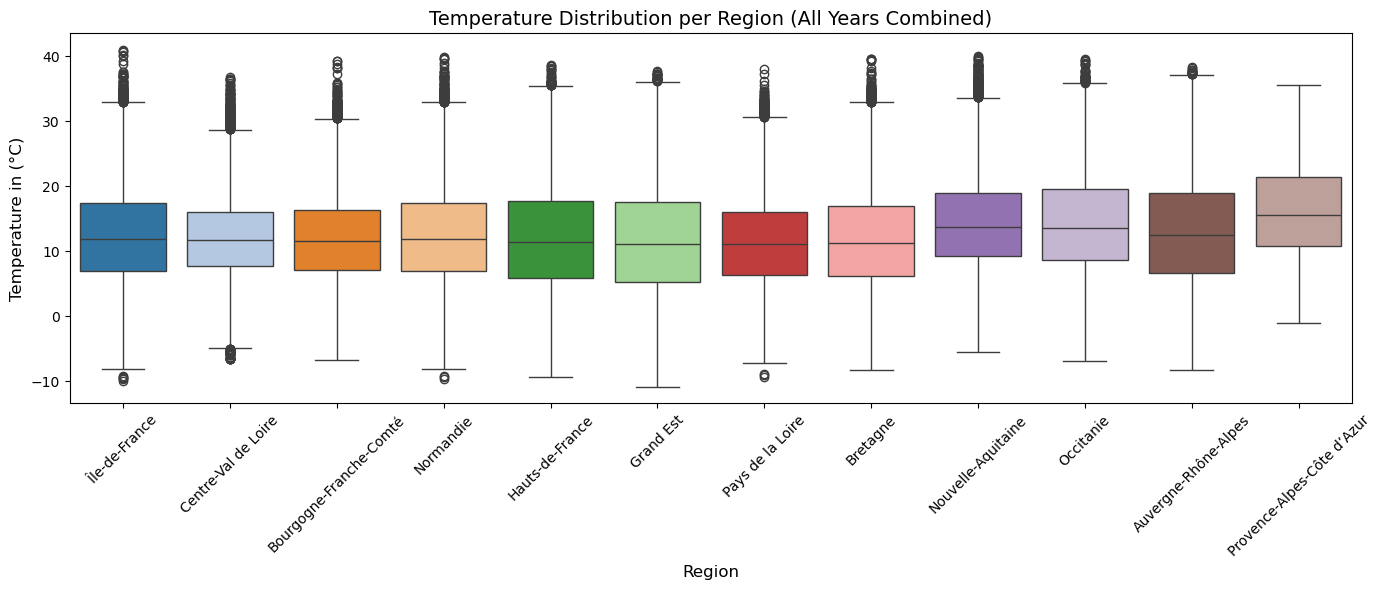

In [9]:
#Creating temperature boxplots per region

plt.figure(figsize=(14, 6))

# Boxplot that collects all temperature for all years
sns.boxplot(
    data=df,
    x="region_name",
    y="temperature_2m",
    hue="region_name",  # to get colors for each region
    dodge=False,        
    palette="tab20",
    legend=False        
)

plt.title("Temperature Distribution per Region (All Years Combined)", fontsize=14)
plt.xlabel("Region", fontsize = 12)
plt.ylabel("Temperature in (°C)", fontsize = 12)
plt.xticks(rotation=45)  # rotate region labels if needed
plt.tight_layout()
plt.savefig("Temperature_Distribtuion_Per_Region_Boxplot.pdf", format='pdf', bbox_inches='tight')
plt.show()


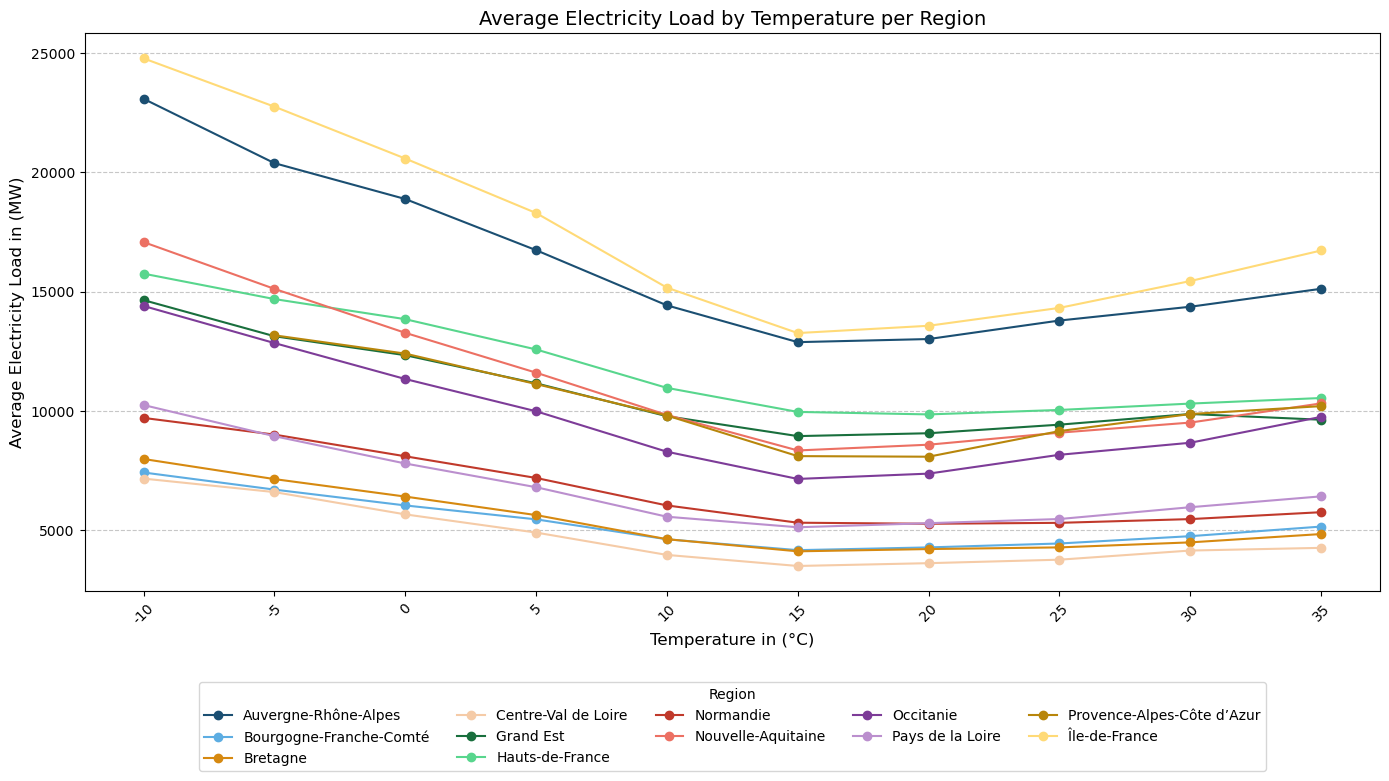

In [11]:
# Defining the temperate bins on the x-as with steps of5 degrees
bins = np.arange(-10, 45, 5)
bin_labels = bins[:-1]
df["temp_bin"] = pd.cut(df['temperature_2m'], bins=bins, labels=bin_labels, right=False)


#Grouping by region and temperature to calculate average load on all regions
avg_load_region = (
    df.groupby(["region_name", "temp_bin"], observed = True)["conso_elec_mw"]
    .mean()
    .reset_index()
)


#Temp_bin needs converting to numeric otherwise we cannot plot
avg_load_region['temp_bin_num'] = avg_load_region['temp_bin'].astype(int)

# Defining 12 distinct colors as best as possible 
colors = [
    "#1B4F72", "#5DADE2",     # blue, light blue
    "#D68910", "#F5CBA7",     # orange, light orange
    "#196F3D", "#58D68D",     # green, light green
    "#C0392B", "#EC7063",     # red, light red
    "#7D3C98", "#BB8FCE",     # purple, light purple
    "#B8860B", "#FFDA77"      # gold, light gold  
]



# Creating plot with 1 line for each region
plt.figure(figsize=(14, 8))
regions = avg_load_region["region_name"].unique()

for i, region in enumerate(regions):
    region_data = avg_load_region[avg_load_region["region_name"] == region]
    plt.plot(
        region_data["temp_bin_num"],  
        region_data["conso_elec_mw"],
        marker="o",
        label=region,
        color=colors[i]  
    )

plt.xticks(
    ticks=avg_load_region['temp_bin_num'].unique(),
    labels=avg_load_region['temp_bin'].unique(),
    rotation=45
)

plt.xlabel("Temperature in (°C)", fontsize=12)
plt.ylabel("Average Electricity Load in (MW)", fontsize=12)
plt.title("Average Electricity Load by Temperature per Region", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Region", loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.tight_layout()
plt.savefig("Temperature_Change_To_Load_view.pdf", format='pdf', bbox_inches='tight')
plt.show()


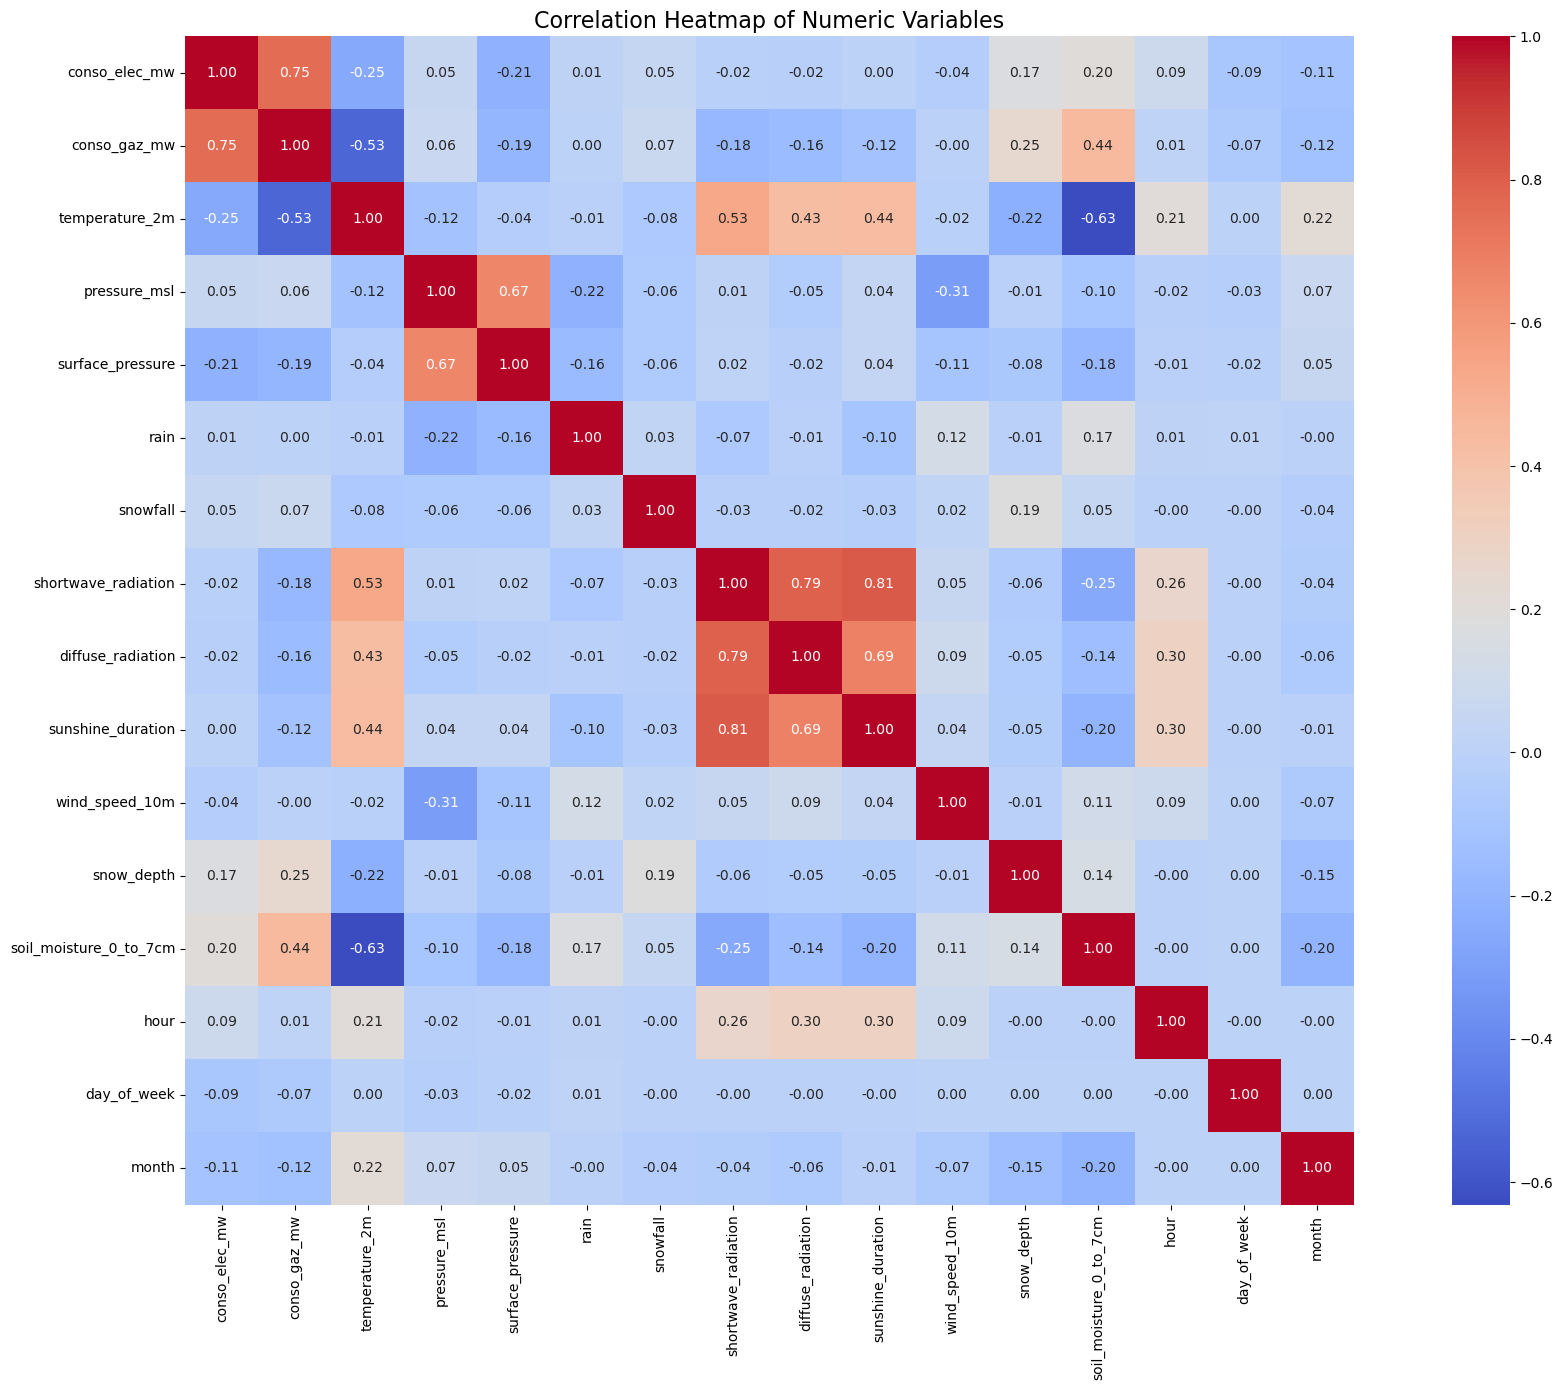

In [35]:
#Creating the correlation matrix to check if features can be deleted in the feature engineering part
numeric_cols = df.select_dtypes(include=["float32", "int32"]).columns

# Computing the correlation matrix
corr = df[numeric_cols].corr()

# Plotting the heatmap
plt.figure(figsize=(20, 14))
sns.heatmap(
    corr,
    annot=True,      
    fmt=".2f",
    cmap="coolwarm", 
    cbar=True,
    square=True
)
plt.title("Correlation Heatmap of Numeric Variables", fontsize=16)
plt.tight_layout()
plt.savefig('HeatMap', dpi=150, bbox_inches = 'tight')
plt.show()

C:\Users\sofya\anaconda3\Lib\site-packages\joypy\joyplot.py:176: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(by)


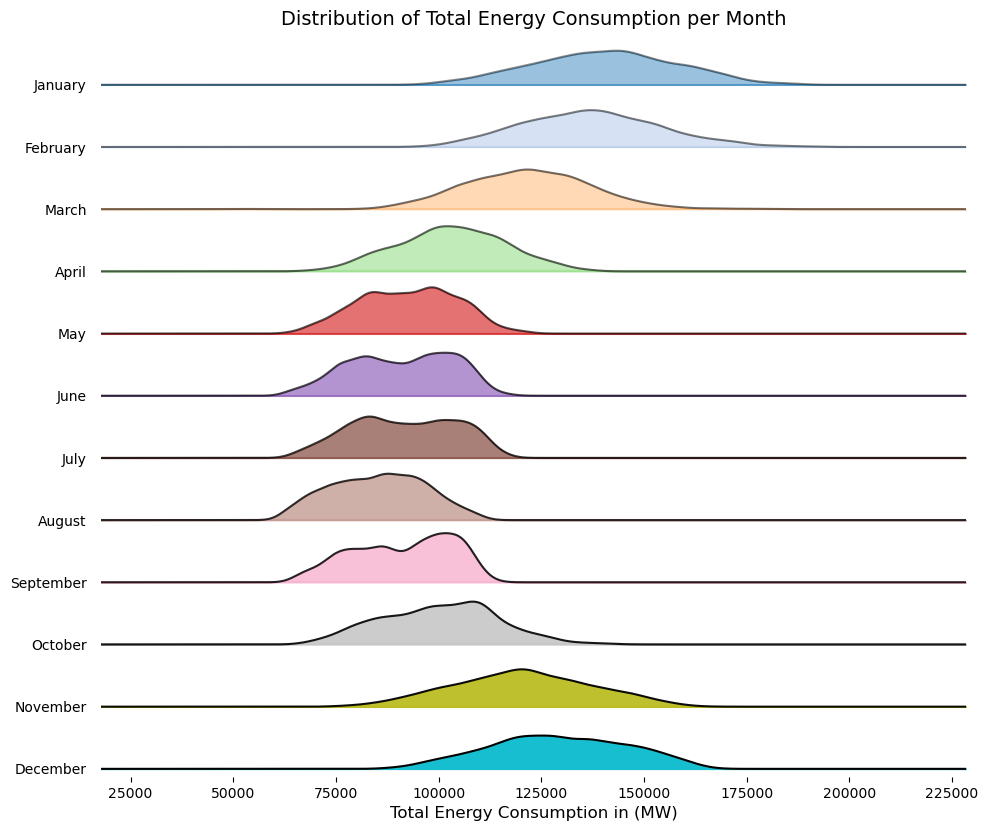

In [13]:
#Creating plot to shwocase monthly shaped electricity load 
#Aggregrating the total demand of all regions to get 1 demand
df_total = df.groupby("datetime_hour")["conso_elec_mw"].sum().reset_index()

# Extracting the month names for nicer plot 
df_total["month"] = df_total["datetime_hour"].dt.month_name()


#Making sure that it has the natural calendar order for nicer plotting
month_order = list(calendar.month_name[1:]) 
df_total["month"] = pd.Categorical(df_total["month"], categories=month_order, ordered=True)

# creating a joypy plot for better viewing
fig, axes = joypy.joyplot(
    data=df_total,
    by="month",
    column="conso_elec_mw",
    colormap=plt.cm.tab20,
    kind="kde",
    overlap=0,          
    figsize=(10, 8),
    fade=True
)

plt.title("Distribution of Total Energy Consumption per Month", fontsize=14)
plt.xlabel("Total Energy Consumption in (MW)", fontsize = 12)
plt.savefig("Monthly_Distribution_shape_yearly_load.pdf", format='pdf', bbox_inches='tight')
plt.show()

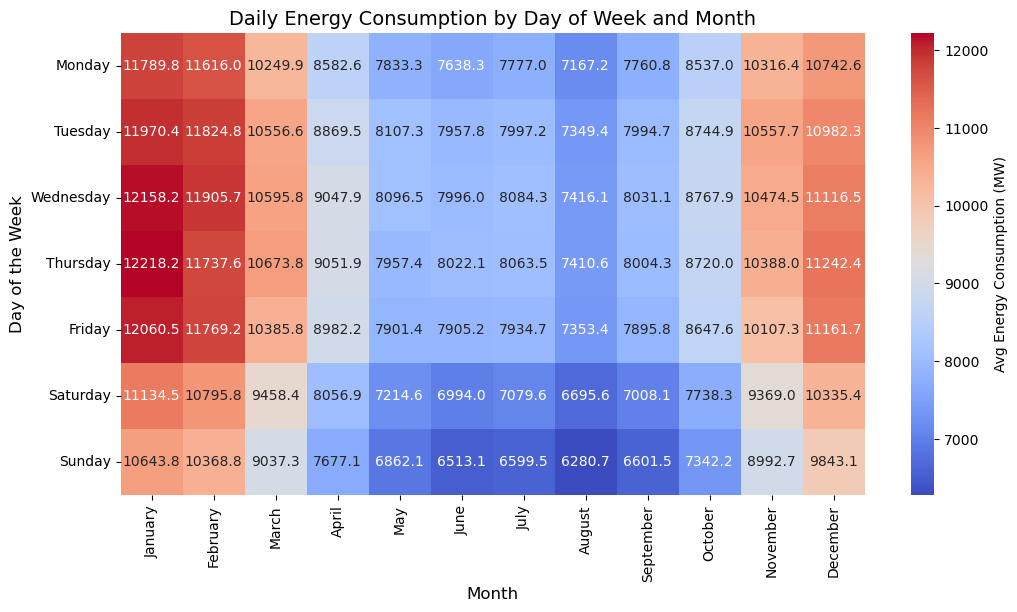

In [15]:
#Creating the day names of the week and the month names for plotting
df['day_name'] = df['datetime_hour'].dt.day_name()  
df['month_name'] = df['datetime_hour'].dt.month_name()  


#Aggregating the electricity load average by day of week and month of all regions
heatmap_data = df.pivot_table(
    index='day_name',
    columns='month_name',
    values='conso_elec_mw',
    aggfunc='mean'
)

# making sure that the weekdays and months are in calendar order for the plot
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heatmap_data = heatmap_data.reindex(weekday_order)
month_order = [calendar.month_name[i] for i in range(1, 13)]
heatmap_data = heatmap_data[month_order]

# Plotting the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap="coolwarm",
    cbar_kws={'label': 'Avg Energy Consumption (MW)'}
)
plt.title("Daily Energy Consumption by Day of Week and Month", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Day of the Week", fontsize=12)
plt.savefig("Daily_Consumption_Per_day_per_month.pdf", format='pdf', bbox_inches='tight')
plt.show()


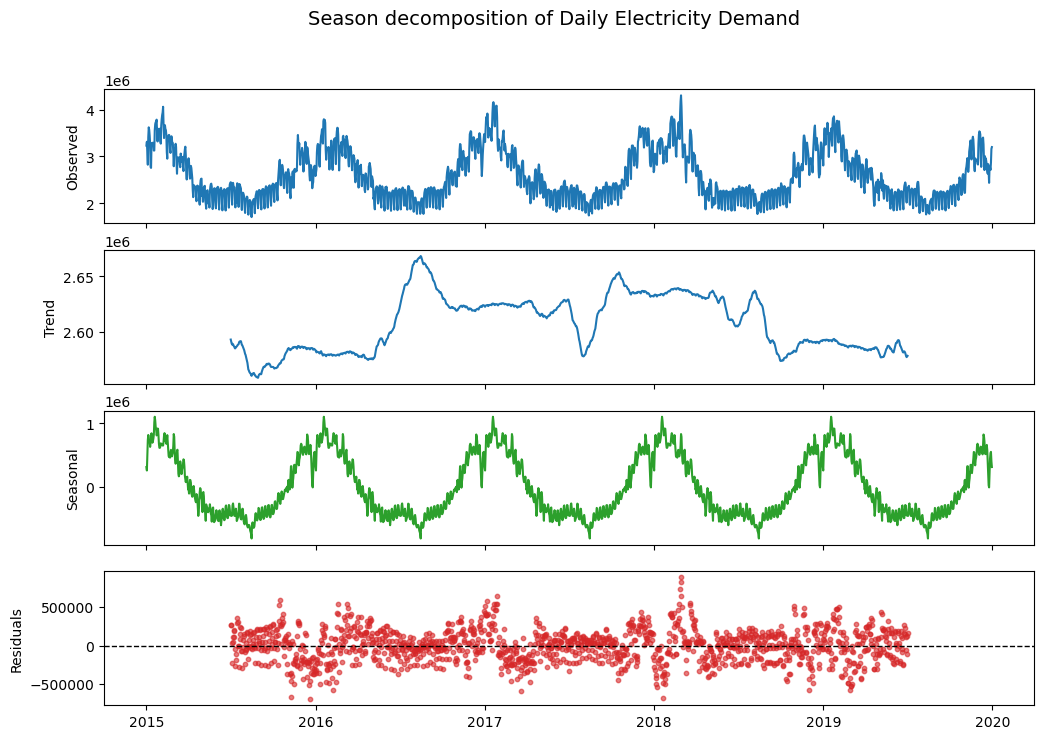

In [17]:
#Creating the seasonal decomposition plot
#Aggregate electricity load to daily demand
daily_france = df.groupby('datetime_hour')['conso_elec_mw'].sum().resample('D').sum()


#seasonal deocmpose the yearly load
result = seasonal_decompose(daily_france, model = 'additive', period = 365)


#creating the figures
fix, axes = plt.subplots(4,1, figsize = (12,8), sharex = True)
axes[0].plot(result.observed, label = 'Actual Load')
axes[0].set_ylabel('Observed')


axes[1].plot(result.trend, label = 'Trend', color = 'tab:blue')
axes[1].set_ylabel('Trend')


axes[2].plot(result.seasonal, label = 'Seasonality', color = 'tab:green')
axes[2].set_ylabel('Seasonal')

axes[3].scatter(result.resid.index, result.resid, label = 'Residuals', color='tab:red', s=10, alpha = 0.6)
axes[3].axhline(0, color = 'black', linewidth = 1, linestyle = '--')
axes[3].set_ylabel('Residuals')
axes[3].grid(False)


plt.suptitle('Season decomposition of Daily Electricity Demand', fontsize = 14)
plt.savefig("Seasonal_Decomposition_Daily_Demand_new.pdf", format='pdf', bbox_inches='tight')
plt.show()

<Figure size 1200x400 with 0 Axes>

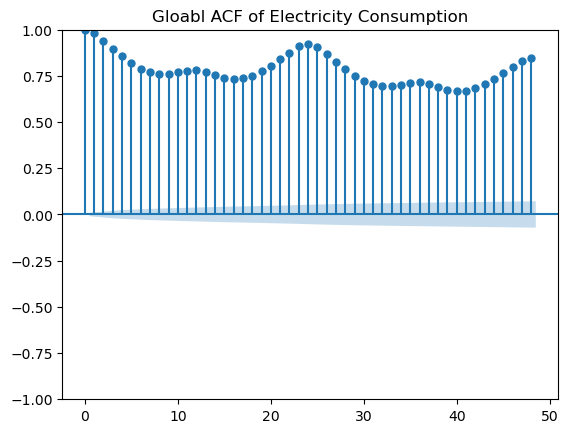

<Figure size 1200x400 with 0 Axes>

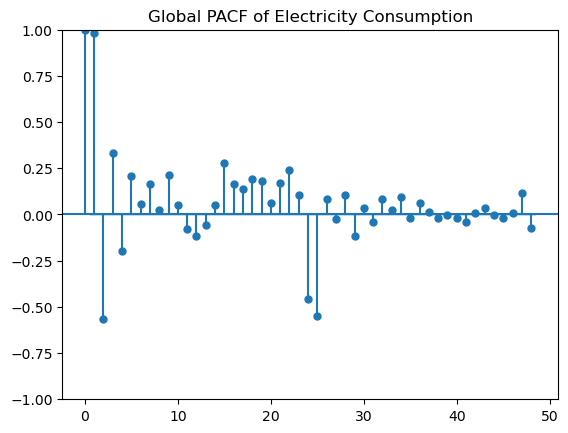

In [19]:
#aggregating the hourly mean of the electricity load of all regions
y_global = df.groupby('datetime_hour')['conso_elec_mw'].mean()

#creating the ACF plot
plt.figure(figsize=(12,4))
plot_acf(y_global, lags = 48)
plt.title('Gloabl ACF of Electricity Consumption')
plt.savefig("Autocorrelation_of_daily_energy_consumption.pdf", format='pdf', bbox_inches='tight')
plt.show()

#creating the PACF plot
plt.figure(figsize = (12,4))
plot_pacf(y_global, lags = 48)
plt.title('Global PACF of Electricity Consumption')
plt.savefig("Partial_Autocorrelation_of_daily_energy_consumption.pdf", format='pdf', bbox_inches='tight')
plt.show()

